[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/integrations/openai/beyond_search_webinar/00_multi-extraction.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/integrations/openai/beyond_search_webinar/00_multi-extraction.ipynb)

## Transform data into larger chunks of around 500 tokens
This assumes that the dataset is ordered sequentially. If this is not the case, then this part should be skipped

In [ ]:
!pip install openai pandas transformers

In [1]:
import pandas as pd
import openai

openai.api_key = '<<YOUR_API_KEY>>'  # beta.openai.com/login/

hf = pd.read_json('data/huggingface-qa.jsonl', lines=True)
pt = pd.read_json('data/pytorch-qa.jsonl', lines=True)
tf = pd.read_json('data/tensorflow-qa.jsonl', lines=True)
sl = pd.read_json('data/streamlit-qa.jsonl', lines=True)
df = pd.concat([hf, pt, tf, sl], ignore_index=True)
df.sample(5)

,docs,category,thread,href,question,context,marked
3801,pytorch,Captum,GradCam - Zero output,https://discuss.pytorch.org/t/gradcam-zero-out...,"Hello everyone,\nI just started to dig into Ex...","Hi @Francesco_Grimaldi, this is a surprising r...",0
2766,pytorch,vision,Dynamic vs static set of images,https://discuss.pytorch.org/t/dynamic-vs-stati...,I have a problem where I want to create a netw...,You can train for a large set and pad shorter ...,0
5802,streamlit,Streamlit Cloud,How to limit max upload size on share.streamli...,https://discuss.streamlit.io/t/how-to-limit-ma...,Hello\nI am trying to connect PostgreSQL on He...,Hi @frances \nStreamlit looks at your requirem...,1
4157,tensorflow,General Discussion,Clear the graph and free the GPU memory in Ten...,https://discuss.tensorflow.org/t/clear-the-gra...,"I’m training multiple models sequentially, whi...",We had another thread about this at:\n\n \n ...,0
2385,huggingface,🤗Tokenizers,How to add additional custom pre-tokenization ...,https://discuss.huggingface.co/t/how-to-add-ad...,I would like to add a few custom functions for...,Hi @reSearch2vec\nThere are multiple ways to c...,0


In [2]:
df.values[5080]

array(['streamlit', 'Using Streamlit',
       '50MB dataset limitation when using Plotly.py',
       'https://discuss.streamlit.io/t/50mb-dataset-limitation-when-using-plotly-py/9464',
       'Hi there,\nI’m using Plotly.py to show figures in my Streamlit app with big datasets. And now I get a notification of dataset oversizing, bigger than 50.0MB, is there anyway to solve this?',
       'Thanks for the reply! I found this github link before I posted this issue, but it didn’t solve my problem.\nBut later my friends and I found this error message in ~/site-packages/streamlit/server/server_util.py, and changed the parameter MESSAGE_LIMIT_SIZE to 200*1e6, making the write limit now 200 MB',
       1], dtype=object)

In [3]:
df.docs.value_counts()

huggingface    2765
tensorflow     1224
streamlit      1115
pytorch        1061
Name: docs, dtype: int64

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1718 > 1024). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

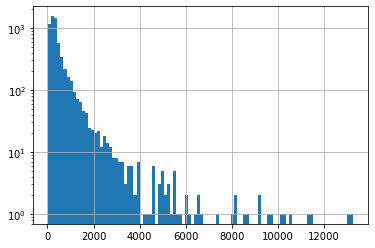

In [4]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ', regex=False)
    serie = serie.str.replace('\\n', ' ', regex=False)
    serie = serie.str.replace('  ',' ', regex=False)
    serie = serie.str.replace('  ',' ', regex=False)
    return serie


from transformers import GPT2TokenizerFast

df['text'] = "Topic: " + df.docs + " - " + df.category + "; Question: " + df.thread + " - " + df.question + "; Answer: " + df.context
df['text'] = remove_newlines(df.text)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df.n_tokens.hist(bins=100, log=True)

<AxesSubplot:>

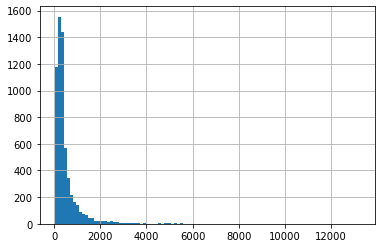

In [5]:
df.n_tokens.hist(bins=100)

In [6]:
df = df[df.n_tokens < 2000]

## Get Embeddings, and save them

In [7]:
size = 'curie'

from openai.embeddings_utils import get_embedding

df['embeddings'] = df.text.apply(lambda x: get_embedding(x, engine=f'text-search-{size}-doc-001'))
df.to_parquet('data/curie_embeddings.parquet')
df.head()

,docs,category,thread,href,question,context,marked,text,n_tokens
0,huggingface,Beginners,Can’t download (some) models although they are...,https://discuss.huggingface.co/t/cant-download...,"Can’t download (some) models to pytorch, altho...",Looking at umarayub/t5-small-finetuned-xsum at...,0,Topic: huggingface - Beginners; Question: Can’...,550
1,huggingface,Beginners,"Trainer.push_to_hub is taking lot of time, is ...",https://discuss.huggingface.co/t/trainer-push-...,"Hi, I’m trying to push my model to HF hub via ...",@sgugger can you please help me out with this...,0,Topic: huggingface - Beginners; Question: Trai...,204
2,huggingface,Beginners,SSLCertVerificationError when loading a model,https://discuss.huggingface.co/t/sslcertverifi...,I am exploring potential opportunities of usin...,I’m also getting the same error. Please let me...,0,Topic: huggingface - Beginners; Question: SSLC...,494
3,huggingface,Beginners,How to use embeddings to compute similarity?,https://discuss.huggingface.co/t/how-to-use-em...,"Hi, I would like to compute sentence similarit...","With transformers, the feature-extraction pipe...",0,Topic: huggingface - Beginners; Question: How ...,351
4,huggingface,Beginners,How to use additional input features for NER?,https://discuss.huggingface.co/t/how-to-use-ad...,"Hello,\nI’ve been following the documentation ...","mhl:\n\ne.g [“Arizona_NNP”, “Ice_NNP”, “Tea_NN...",0,Topic: huggingface - Beginners; Question: How ...,1718
